# Author Details:

### **Name: Muhammad Hamid**
### **linkedin** :https://www.linkedin.com/in/muhammad-hamid-87242a312/
### **GitHub**: https://github.com/hamid4386

In [14]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [15]:
# loading data set
df = pd.read_csv("AAPL.csv")

## check data for unwanted things like missing values etc

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11021 entries, 0 to 11020
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       11021 non-null  object 
 1   Open       11021 non-null  float64
 2   High       11021 non-null  float64
 3   Low        11021 non-null  float64
 4   Close      11021 non-null  float64
 5   Adj Close  11021 non-null  float64
 6   Volume     11021 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 602.8+ KB


In [17]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

### Data Loading and Preprocessing
In this step, we will perform some preprocessing like normalization. The data will be moved to the GPU if available.


In [18]:
closed_prices = df["Close"]

seq_len = 20

mm = MinMaxScaler()
scaled_price = mm.fit_transform(np.array(closed_prices)[..., None]).squeeze()

X = []
y = []

for i in range(len(scaled_price) - seq_len):
    X.append(scaled_price[i: i + seq_len])
    y.append(scaled_price[i + seq_len])

X = np.array(X)[..., None]
y = np.array(y)[..., None]

# Convert to PyTorch tensors and move to the selected device (GPU/CPU)
train_x = torch.from_numpy(X[:int(0.8 * X.shape[0])]).float().to(device)
train_y = torch.from_numpy(y[:int(0.8 * X.shape[0])]).float().to(device)
test_x = torch.from_numpy(X[int(0.8 * X.shape[0]):]).float().to(device)
test_y = torch.from_numpy(y[int(0.8 * X.shape[0]):]).float().to(device)


In [19]:
closed_prices.shape

(11021,)

### Define the LSTM Model
Here, we define a simple LSTM model using PyTorch. The model has an LSTM layer followed by a fully connected layer. The model is moved to the GPU if available.


In [20]:
# Cell 3: Define the LSTM model class
class Model(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        output, (hidden, cell) = self.lstm(x)
        return self.fc(hidden[-1, :])

# Initialize the model and move it to the selected device
model = Model(1, 64).to(device)


### Define Loss Function and Optimizer
We'll use Mean Squared Error (MSE) as the loss function and Adam optimizer for the training process.


In [21]:
# Cell 4: Set up the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()
num_epochs = 100


### Train the Model
In this step, we train the LSTM model for a specified number of epochs, printing the loss every 10 epochs. The training will be performed on the GPU if available.


In [22]:
# Cell 5: Train the model
for epoch in range(num_epochs):
    model.train()
    output = model(train_x)  # Forward pass
    loss = loss_fn(output, train_y)  # Compute loss

    optimizer.zero_grad()  # Zero the gradients
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights
    print(epoch, "epoch loss", loss.detach().cpu().numpy())  # Detach and move to CPU for printing

0 epoch loss 0.023087023
1 epoch loss 0.000982509
2 epoch loss 0.010871777
3 epoch loss 0.0029876719
4 epoch loss 0.00094286335
5 epoch loss 0.0022958724
6 epoch loss 0.0033334761
7 epoch loss 0.0031072192
8 epoch loss 0.0022446734
9 epoch loss 0.001405061
10 epoch loss 0.00092150405
11 epoch loss 0.00085118855
12 epoch loss 0.0010644683
13 epoch loss 0.001332067
14 epoch loss 0.0014540408
15 epoch loss 0.0013724524
16 epoch loss 0.0011635926
17 epoch loss 0.00094707595
18 epoch loss 0.0008079896
19 epoch loss 0.0007712514
20 epoch loss 0.0008138231
21 epoch loss 0.00088984246
22 epoch loss 0.000953709
23 epoch loss 0.0009754262
24 epoch loss 0.0009468722
25 epoch loss 0.00087982154
26 epoch loss 0.000798127
27 epoch loss 0.00072742277
28 epoch loss 0.000685733
29 epoch loss 0.000677742
30 epoch loss 0.00069439964
31 epoch loss 0.0007179467
32 epoch loss 0.0007303216
33 epoch loss 0.00072110404
34 epoch loss 0.0006911537
35 epoch loss 0.00065048854
36 epoch loss 0.0006122032
37 epoch l

### Model Evaluation
After training, we evaluate the model on the test dataset and compare the predicted stock prices with the actual stock prices. The evaluation is done on the GPU if available.


In [1]:
# Cell 6: Evaluate the model
model.eval()
with torch.no_grad():
    output = model(test_x)

# Convert the output and test labels back to NumPy arrays and move them to CPU
pred = mm.inverse_transform(output.cpu().numpy())
real = mm.inverse_transform(test_y.cpu().numpy())


NameError: name 'model' is not defined

### Plot Predictions vs. Real Data
Finally, we'll plot the predicted stock prices vs. the real stock prices to visually assess the performance of our model.


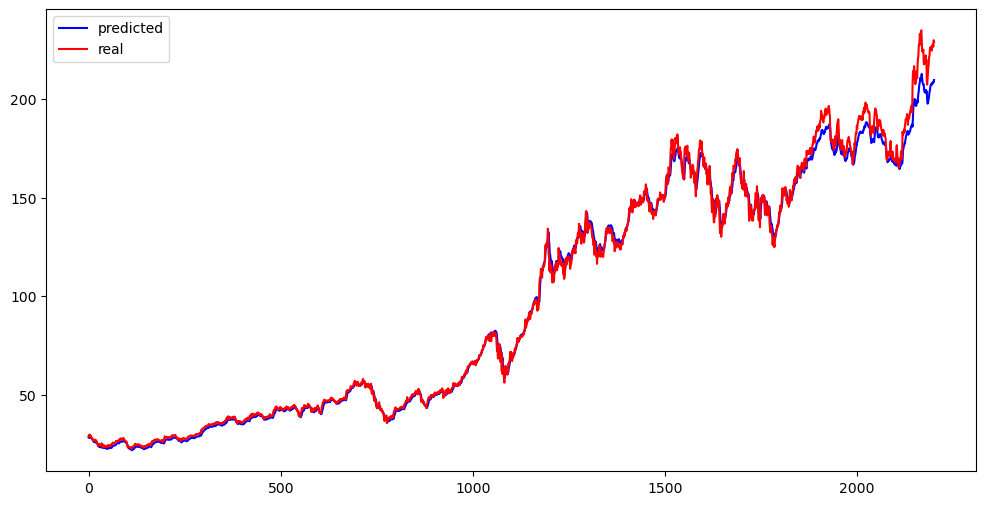

In [24]:
# Cell 7: Plot the results
plt.figure(figsize=(12, 6))
plt.plot(pred.squeeze(), color="blue", label="predicted")
plt.plot(real.squeeze(), color="red", label="real")
plt.legend()
plt.show()


In [162]:
# Save the model
torch.save(model.state_dict(), "model.pth")
